In [26]:
!pip install -q tensorflow scikit-learn matplotlib


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
train_dir = r"C:\Users\user\Downloads\data\train"
val_dir   = r"C:\Users\user\Downloads\data\val"

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False   # keep order for confusion matrix
)

class_names = list(train_data.class_indices.keys())
print("Classes:", class_names)


Found 275 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Classes: ['cat', 'dog']


In [11]:

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [12]:
# --------------------- 3. Feature Extraction Training ---------------------
INITIAL_EPOCHS = 5

history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=INITIAL_EPOCHS
)

C:\Users\user\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.7018 - loss: 0.5819 - val_accuracy: 0.8429 - val_loss: 0.3966
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.9273 - loss: 0.2566 - val_accuracy: 0.9571 - val_loss: 0.2099
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9527 - loss: 0.1654 - val_accuracy: 0.9571 - val_loss: 0.1472
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.9527 - loss: 0.1178 - val_accuracy: 0.9714 - val_loss: 0.1221
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.9600 - loss: 0.1046 - val_accuracy: 0.9714 - val_loss: 0.0989


In [13]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

history2 = model.fit(
    train_data,
    validation_data=val_data,
    initial_epoch=INITIAL_EPOCHS,
    epochs=TOTAL_EPOCHS
)


Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 658s 61s/step - accuracy: 0.8182 - loss: 0.4002 - val_accuracy: 0.9714 - val_loss: 0.0859
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 285s 28s/step - accuracy: 0.8873 - loss: 0.3005 - val_accuracy: 0.9714 - val_loss: 0.0744
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 534s 63s/step - accuracy: 0.8945 - loss: 0.2479 - val_accuracy: 0.9714 - val_loss: 0.0665
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 179s 15s/step - accuracy: 0.9127 - loss: 0.2053 - val_accuracy: 0.9714 - val_loss: 0.0612
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 170s 19s/step - accuracy: 0.9491 - loss: 0.1473 - val_accuracy: 0.9714 - val_loss: 0.0570


In [14]:
# --------------------- 5. Evaluation ---------------------
val_data.reset()
pred_probs = model.predict(val_data)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_data.classes

3/3 ━━━━━━━━━━━━━━━━━━━━ 111s 29s/step


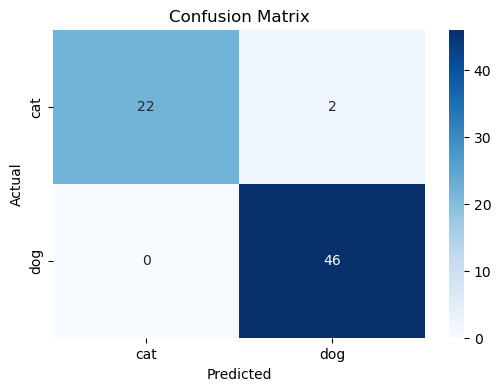

In [15]:
# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
model.save("Classification_model.keras")
